# Quantum mechanics in PINN
We solve time independent Schrodinger equation and determine the energy eigenvalue
\begin{equation}
-\frac{\hbar^2}{2m}\frac{d^2}{dx^2}\psi(x) + V(x)\psi(x) -E_n \psi(x)=0
\end{equation}

As an example, we take
\begin{equation}
V(x) = \frac{1}{2} kx^2.
\end{equation}

We let $k=1$ and $\hbar^2/m=1$. In these units, the energy eigenvalues are
\begin{equation}
E_n = n+\frac{1}{2}\  \ \ \ \ (n=1,2,\ldots)
\end{equation}

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import numpy as np
from diffutils import *

In [184]:
xin = tfk.layers.Input((1,))
h1 = tfk.layers.Dense(128, activation='swish')(xin)
h1 = tfk.layers.Dense(128, activation='swish')(h1)
out = tfk.layers.Dense(1, activation=None)(h1) # real valued wave function

psi = tfk.Model(xin, out)

In [185]:
def V(x):
    #return tf.where(tf.math.logical_or(x<-1.0, x>1.0), tf.constant(10.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32))
    return 0.5*tf.square(x)

In [186]:
@tf.function
def lossfn(wavefn, x, En):
    return -0.5*D1(wavefn, x, 2)  + V(x) * wavefn(x) - En*wavefn(x)

In [187]:
optimizer = tf.optimizers.Adam(learning_rate = 0.01)

In [188]:
xlo = -6.0
xhi = 6.0
npoints = 10000
deltah = (xhi-xlo)/(npoints-1)
xin = np.linspace(xlo, xhi, npoints).reshape((npoints, 1)).astype(np.float32)
En = 0.3

xin_tf = tf.convert_to_tensor(xin)


In [189]:
@tf.function
def train_step(En_tf, c):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(En_tf)
        H = lossfn(psi, xin_tf, En_tf)
        psis = psi(xin_tf)
        Lnorm = tf.reduce_sum(tf.square(psis)) * deltah
        Hloss = tf.reduce_mean(tf.square(H))  / Lnorm
        BCloss = tf.square(psis[0,0]) + tf.square(psis[-1, 0])
        Lnormloss = tf.square(Lnorm-1.0)
        Lreg = 1e-7*tf.exp(-En_tf + c)
        loss = 10.0*Hloss + Lnormloss + BCloss 


    grad = tape.gradient(loss, psi.trainable_variables)
    optimizer.apply_gradients(zip(grad, psi.trainable_variables))

    gradEn = tape.gradient(loss, En_tf, unconnected_gradients='zero')
    En_tf = En_tf - 0.0005*gradEn

    return loss, En_tf, Hloss, Lnormloss, BCloss, Lreg
train_hist = []
def train(nsteps=10000, start=0.5, end=3.0, nscans=20):
    deltascan = (end-start)/nscans
    for cscan in range(nscans):
        c = tf.constant(start + deltascan * cscan, dtype=tf.float32)
        En_tf = tf.Variable(c)
        for istep in range(nsteps):
            L, En_tfnew, Hloss, Lnormloss, BCloss, Lreg= train_step(En_tf, c)
            train_hist.append([L.numpy(), En_tfnew.numpy(), Hloss.numpy(), Lnormloss.numpy(), BCloss.numpy(), Lreg.numpy()])
            En_tf = En_tfnew
            if istep%1000 == 0:
                print(f'{istep}: {L.numpy():.2e} En={En_tf.numpy():.2e}')
        

    return En_tf.numpy()

In [ ]:
En = train(10000, 0.4, 4.0, 10)

In [191]:
psi(xin)

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[1.6312917e-04],
       [1.6315599e-04],
       [1.6127720e-04],
       ...,
       [6.5598171e-05],
       [6.6962064e-05],
       [6.6453402e-05]], dtype=float32)>

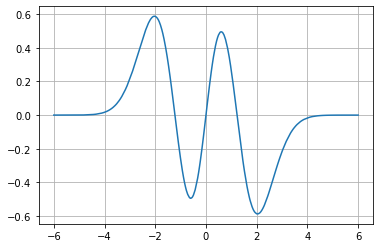

In [192]:
%matplotlib inline
plt.plot(xin, psi(xin))
plt.grid()
plt.show()

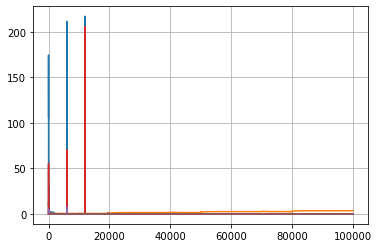

In [193]:
%matplotlib inline
plt.plot(train_hist)
plt.grid()

In [194]:
train_hist_np = np.array(train_hist)

In [195]:
import pandas as pd

df = pd.DataFrame(train_hist_np, columns=['Loss', 'En', 'Hloss', 'Lnormloss', 'BCloss', 'Lreg'])

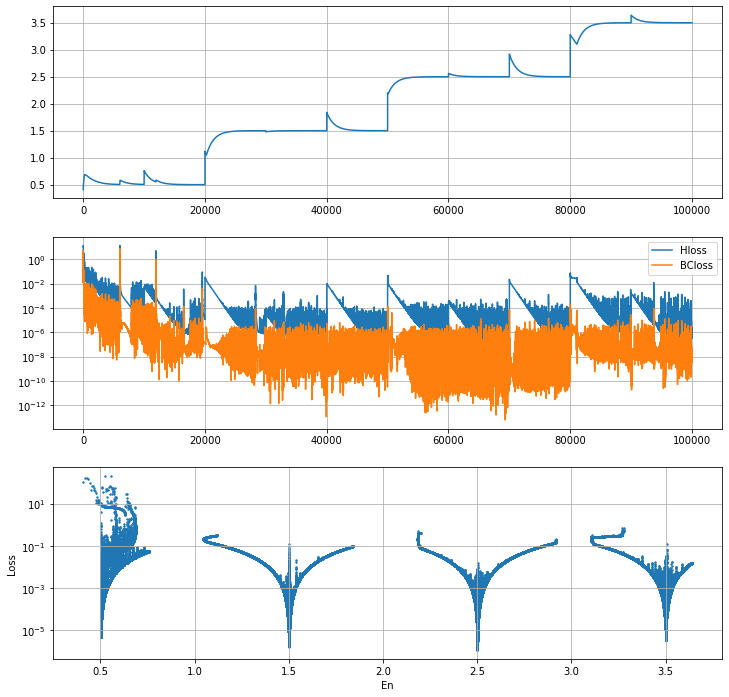

In [196]:
%matplotlib inline
fig, ax  = plt.subplots(3,1,figsize=(12,12))
plt.sca(ax[0])
df['En'].plot(ax=ax[0])
plt.grid()
plt.sca(ax[1])
df[['Hloss', 'BCloss']].plot(ax=ax[1])
ax[1].set_yscale('log')
plt.grid()
plt.sca(ax[2])
df.plot.scatter('En', 'Loss', 2, ax=ax[2])
plt.gca().set_yscale('log')
plt.grid()

<AxesSubplot:>

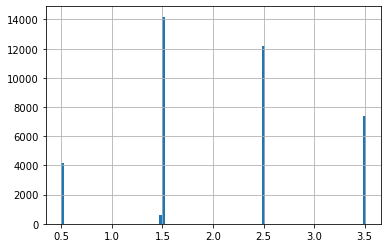

In [198]:
# These are the energy eigenvalues.
df[df['Loss']<1e-4]['En'].hist(bins=100)